In [1]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

In [2]:
chartLab24 = pd.read_csv("../Code/output/chartLab24Item20.csv")

In [3]:
patients = pd.read_csv("../Code/output/patientsinfo.csv")

In [21]:
patients.head()

,SUBJECT_ID,HADM_ID,Age,GENDER,HOSPITAL_EXPIRE_FLAG
0,22,165315,64.97,F,0
1,23,152223,71.18,M,0
2,23,124321,75.31,M,0
3,24,161859,39.04,M,0
4,25,129635,58.99,M,0


In [25]:
patients[['GENDER_num']] = patients['GENDER'].apply(lambda x: 0 if x=='M' else 1)

In [26]:
patients.head()

,SUBJECT_ID,HADM_ID,Age,GENDER,HOSPITAL_EXPIRE_FLAG,GENDER_num
0,22,165315,64.97,F,0,1
1,23,152223,71.18,M,0,0
2,23,124321,75.31,M,0,0
3,24,161859,39.04,M,0,0
4,25,129635,58.99,M,0,0


In [4]:
chartLab24.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00


In [5]:
chartLab24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12018539 entries, 0 to 12018538
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 458.5+ MB


# Data cleaning

In [6]:
def chart_cleaning(df):
    # GLU
    df = df.drop(df[(df.ITEMID=='GLU') & (df.VALUE>5000)].index)
    # DBP
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE<0)].index)
    # FIO -- ignore
    # df = df.drop(df[(df.ITEMID=='FIO') & (df.VALUE>100)].index)
    # HEIGHT
    df = df.drop(df[(df.ITEMID=='HEIGHT') & (df.VALUE>300)].index)
    # HR
    df = df.drop(df[(df.ITEMID=='HR') & (df.VALUE>10000)].index)
    # MBP
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE<0)].index)
    # OS
    df = df.drop(df[(df.ITEMID=='OS') & (df.VALUE>10000)].index)
    # PH
    df = df.drop(df[(df.ITEMID=='PH') & (df.VALUE>10)].index) 
    # RESPR
    df = df.drop(df[(df.ITEMID=='RESPR') & (df.VALUE>1000)].index)
    # SBP
    df = df.drop(df[(df.ITEMID=='SBP') & (df.VALUE>1000)].index)
    # TEMP
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE>50)].index) 
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE<20)].index)
    # weight
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE>1000)].index) 
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE<10)].index)

    return df

In [7]:
chartLab24 = chart_cleaning(chartLab24)

In [8]:
chartLab24.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12016337 entries, 0 to 12018538
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 550.1+ MB


# Data preprocessing

In [9]:
chartLab24[['TIME']] = chartLab24['CHARTTIME'].apply(lambda x: x[:10] +' '+ x[11:13])

In [10]:
chartLab24.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,TIME
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00,2134-05-12 12
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29,2134-05-12 12
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00,2134-05-12 13
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00,2134-05-12 13
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00,2134-05-12 13


In [11]:
chartLab24_hourly = chartLab24[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'TIME']].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'TIME'], as_index=False).mean()

In [12]:
chartLab24_hourly.head()

,SUBJECT_ID,HADM_ID,ITEMID,TIME,VALUE
0,3,145834,DBP,2101-10-20 18,24.000000
1,3,145834,DBP,2101-10-20 19,36.200000
2,3,145834,DBP,2101-10-20 20,47.125000
3,3,145834,DBP,2101-10-20 21,44.375000
4,3,145834,DBP,2101-10-20 22,67.666667


In [13]:
chartLab24_hourly.info() ## 8406543 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8406543 entries, 0 to 8406542
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   TIME        object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 384.8+ MB


In [14]:
items20 = chartLab24['ITEMID'].unique()

In [15]:
items20

array(['FIO', 'PH', 'HR', 'SBP', 'DBP', 'MBP', 'RESPR', 'OS', 'TEMP',
       'WEIGHT', 'GLU', 'HEIGHT', 'GO', 'GT', 'GMR', 'GVR', 'CRR', 'UREA',
       'WBC', 'POTA'], dtype=object)

In [16]:
chartLab24_hourly_pivot = chartLab24_hourly.pivot(index = ['HADM_ID', 'TIME'],columns='ITEMID', values = 'VALUE')

In [17]:
chartLab24_hourly_pivot.tail()

ITEMID                 CRR   DBP   FIO    GLU  GMR   GO  GT  GVR  HEIGHT  \
HADM_ID TIME                                                               
199999  2136-04-07 12  NaN  52.0  80.0    NaN  6.0  4.0 NaN  5.0     NaN   
        2136-04-07 13  NaN  57.0   NaN    NaN  NaN  NaN NaN  NaN     NaN   
        2136-04-07 14  NaN  56.0   NaN    NaN  NaN  NaN NaN  NaN     NaN   
        2136-04-07 15  NaN  58.0   NaN    NaN  NaN  NaN NaN  NaN     NaN   
        2136-04-07 16  NaN  61.0   NaN  138.0  NaN  NaN NaN  NaN     NaN   

ITEMID                   HR   MBP    OS  PH  POTA  RESPR    SBP       TEMP  \
HADM_ID TIME                                                                 
199999  2136-04-07 12  69.0  83.0  94.0 NaN   NaN   27.0  155.0  37.666667   
        2136-04-07 13  76.0  80.0  93.0 NaN   NaN   27.0  144.0        NaN   
        2136-04-07 14  76.0  81.0  93.0 NaN   NaN   29.0  152.0        NaN   
        2136-04-07 15  75.0  83.0  93.0 NaN   NaN   33.0  155.0  38.166667   
        2136-04-07 16  78.0  76.0  95.0 NaN   NaN   27.0  129.0        NaN   

ITEMID                 UREA  WBC  WEIGHT  
HADM_ID TIME                              
199999  2136-04-07 12   NaN  NaN     NaN  
        2136-04-07 13   NaN  NaN     NaN  
        2136-04-07 14   NaN  NaN     NaN  
        2136-04-07 15   NaN  NaN     NaN  
        2136-04-07 16   NaN  NaN     NaN

In [18]:
chartLab24_hourly_pivot2 = chartLab24_hourly_pivot.reset_index()

In [19]:
chartLab24_hourly_pivot2.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,MBP,OS,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,98.01
1,100001,2117-09-11 13,NaN,100.0,NaN,NaN,6.0,4.0,NaN,5.0,...,122.0,NaN,NaN,NaN,22.0,192.0,36.666667,NaN,NaN,NaN
2,100001,2117-09-11 14,NaN,85.0,NaN,208.0,NaN,NaN,NaN,NaN,...,103.0,NaN,NaN,4.2,15.0,165.0,NaN,42.0,NaN,NaN
3,100001,2117-09-11 15,NaN,64.0,NaN,179.5,NaN,NaN,NaN,NaN,...,76.0,NaN,NaN,NaN,15.0,119.0,NaN,NaN,NaN,NaN
4,100001,2117-09-11 16,NaN,84.0,NaN,170.0,6.0,4.0,NaN,5.0,...,105.0,100.0,NaN,NaN,16.0,169.0,36.611111,NaN,NaN,NaN


In [20]:
chartLab24_hourly_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1046769 entries, 0 to 1046768
Data columns (total 22 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   HADM_ID  1046769 non-null  int64  
 1   TIME     1046769 non-null  object 
 2   CRR      3274 non-null     float64
 3   DBP      981090 non-null   float64
 4   FIO      62889 non-null    float64
 5   GLU      305276 non-null   float64
 6   GMR      349937 non-null   float64
 7   GO       331540 non-null   float64
 8   GT       200876 non-null   float64
 9   GVR      347562 non-null   float64
 10  HEIGHT   7966 non-null     float64
 11  HR       999703 non-null   float64
 12  MBP      975531 non-null   float64
 13  OS       970550 non-null   float64
 14  PH       158021 non-null   float64
 15  POTA     134617 non-null   float64
 16  RESPR    983809 non-null   float64
 17  SBP      981371 non-null   float64
 18  TEMP     365708 non-null   float64
 19  UREA     84474 non-null    float64
 20  WB

In [30]:
# join the patients gender and age
chartLab24_hourly_pivot2 = chartLab24_hourly_pivot2.set_index('HADM_ID').join(patients[['HADM_ID', 'Age', 'GENDER_num']].set_index('HADM_ID'), how='inner')


KeyError: "None of ['HADM_ID'] are in the columns"

In [31]:
chartLab24_hourly_pivot2.reset_index(inplace=True)

In [32]:
chartLab24_hourly_pivot2.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,98.01,35.5,1
1,100001,2117-09-11 13,NaN,100.0,NaN,NaN,6.0,4.0,NaN,5.0,...,NaN,NaN,22.0,192.0,36.666667,NaN,NaN,NaN,35.5,1
2,100001,2117-09-11 14,NaN,85.0,NaN,208.0,NaN,NaN,NaN,NaN,...,NaN,4.2,15.0,165.0,NaN,42.0,NaN,NaN,35.5,1
3,100001,2117-09-11 15,NaN,64.0,NaN,179.5,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,119.0,NaN,NaN,NaN,NaN,35.5,1
4,100001,2117-09-11 16,NaN,84.0,NaN,170.0,6.0,4.0,NaN,5.0,...,NaN,NaN,16.0,169.0,36.611111,NaN,NaN,NaN,35.5,1


In [33]:
chartLab24_norm = chartLab24_hourly_pivot2.copy()

In [34]:
for col in chartLab24_norm.columns[2:]:
    chartLab24_norm[[col]] = (chartLab24_norm[[col]] - chartLab24_norm[[col]].min())/(chartLab24_norm[[col]].max()-chartLab24_norm[[col]].min())
    

In [35]:
chartLab24_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.033466,NaN,NaN,NaN,NaN,0.095976,0.05957,1.0
1,100001,2117-09-11 13,NaN,0.112360,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,0.052590,0.467153,0.739448,NaN,NaN,NaN,0.05957,1.0
2,100001,2117-09-11 14,NaN,0.095506,NaN,0.085246,NaN,NaN,NaN,NaN,...,NaN,0.012898,0.035857,0.401460,NaN,0.155556,NaN,NaN,0.05957,1.0
3,100001,2117-09-11 15,NaN,0.071910,NaN,0.073566,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035857,0.289538,NaN,NaN,NaN,NaN,0.05957,1.0
4,100001,2117-09-11 16,NaN,0.094382,NaN,0.069672,1.0,1.0,NaN,1.0,...,NaN,NaN,0.038247,0.411192,0.736843,NaN,NaN,NaN,0.05957,1.0


In [36]:
# fill null with -1
chartLab24_norm.fillna(-1, inplace=True)

In [37]:
chartLab24_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000000,0.033466,-1.000000,-1.000000,-1.000000,-1.0,0.095976,0.05957,1.0
1,100001,2117-09-11 13,-1.0,0.112360,-1.0,-1.000000,1.0,1.0,-1.0,1.0,...,-1.0,-1.000000,0.052590,0.467153,0.739448,-1.000000,-1.0,-1.000000,0.05957,1.0
2,100001,2117-09-11 14,-1.0,0.095506,-1.0,0.085246,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.012898,0.035857,0.401460,-1.000000,0.155556,-1.0,-1.000000,0.05957,1.0
3,100001,2117-09-11 15,-1.0,0.071910,-1.0,0.073566,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000000,0.035857,0.289538,-1.000000,-1.000000,-1.0,-1.000000,0.05957,1.0
4,100001,2117-09-11 16,-1.0,0.094382,-1.0,0.069672,1.0,1.0,-1.0,1.0,...,-1.0,-1.000000,0.038247,0.411192,0.736843,-1.000000,-1.0,-1.000000,0.05957,1.0


In [38]:
chartLab24_norm[['value']] = chartLab24_norm.apply(lambda x: list(x['CRR':]), axis=1)

In [39]:
chartLab24_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num,value
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.000000,0.033466,-1.000000,-1.000000,-1.000000,-1.0,0.095976,0.05957,1.0,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,100001,2117-09-11 13,-1.0,0.112360,-1.0,-1.000000,1.0,1.0,-1.0,1.0,...,-1.000000,0.052590,0.467153,0.739448,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.11235955056179775, -1.0, -1.0, 1.0, 1..."
2,100001,2117-09-11 14,-1.0,0.095506,-1.0,0.085246,-1.0,-1.0,-1.0,-1.0,...,0.012898,0.035857,0.401460,-1.000000,0.155556,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.09550561797752809, -1.0, 0.0852459016..."
3,100001,2117-09-11 15,-1.0,0.071910,-1.0,0.073566,-1.0,-1.0,-1.0,-1.0,...,-1.000000,0.035857,0.289538,-1.000000,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.07191011235955057, -1.0, 0.0735655737..."
4,100001,2117-09-11 16,-1.0,0.094382,-1.0,0.069672,1.0,1.0,-1.0,1.0,...,-1.000000,0.038247,0.411192,0.736843,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.09438202247191012, -1.0, 0.0696721311..."


In [40]:
chartLab24_grouped = chartLab24_norm[['HADM_ID', 'value']].groupby('HADM_ID').agg(lambda x: list(x))

In [43]:
chartLab24_grouped[['num_stamps']] = chartLab24_grouped['value'].apply(lambda x: len(x))

In [44]:
chartLab24_grouped.head()

,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",24
100003,"[[-1.0, 0.04044943820224719, -1.0, 0.022950819...",23
100006,"[[-1.0, 0.09662921348314607, -1.0, -1.0, 1.0, ...",24
100007,"[[-1.0, 0.07191011235955057, -1.0, 0.047131147...",25
100009,"[[-1.0, -1.0, -1.0, 0.045081967213114756, -1.0...",23


In [45]:
chartLab24_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46228 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       46228 non-null  object
 1   num_stamps  46228 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [46]:
# remove the admissions which has more than 30 timestamps
chartLab24_grouped.drop(chartLab24_grouped[chartLab24_grouped['num_stamps']>30].index, inplace=True)

In [47]:
chartLab24_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46102 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       46102 non-null  object
 1   num_stamps  46102 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [48]:
chartLab24_grouped.head()

,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",24
100003,"[[-1.0, 0.04044943820224719, -1.0, 0.022950819...",23
100006,"[[-1.0, 0.09662921348314607, -1.0, -1.0, 1.0, ...",24
100007,"[[-1.0, 0.07191011235955057, -1.0, 0.047131147...",25
100009,"[[-1.0, -1.0, -1.0, 0.045081967213114756, -1.0...",23


In [49]:
chartLab24_valueWithLabel = chartLab24_grouped[['value']].join(patients[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']].set_index('HADM_ID'), how='inner')


In [50]:
# split the data to train and test
chartLab24_shuffle = chartLab24_valueWithLabel.sample(frac=1)
chartLab24_test = chartLab24_shuffle.iloc[:7000, ]
chartLab24_valid = chartLab24_shuffle.iloc[7001:14000, ]
chartLab24_train = chartLab24_shuffle.iloc[14001: ,]


In [51]:
# process train dataset
train_label = chartLab24_train['HOSPITAL_EXPIRE_FLAG'].tolist()
train_data = chartLab24_train['value'].tolist()


'\npack the data which has less than 30 timestamp\ntrain_data_seqs = []\npack_list = [-1]*17\n\nfor a in train_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        train_data_seqs.append(a)\n    else:\n        train_data_seqs.append(a)\n\n'

In [52]:
# process validation dataset
valid_label = chartLab24_valid['HOSPITAL_EXPIRE_FLAG'].tolist()
valid_data = chartLab24_valid['value'].tolist()


'\n# pack the data which has less than 30 timestamp\nvalid_data_seqs = []\npack_list = [-1]*17\n\nfor a in valid_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        valid_data_seqs.append(a)\n    else:\n        valid_data_seqs.append(a)\n     \n'

In [53]:
# process test dataset
test_label = chartLab24_test['HOSPITAL_EXPIRE_FLAG'].tolist()
test_data = chartLab24_test['value'].tolist()


'\ntest_data_seqs = []\npack_list = [-1]*17\nfor a in test_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        test_data_seqs.append(a)\n    else:\n        test_data_seqs.append(a)\n     \n'

# RNN model

In [68]:
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset

from utils import train, evaluate
from plots import plot_learning_curves, plot_confusion_matrix

In [73]:
class MyVariableRNN(nn.Module):
	def __init__(self, dim_input):
		super(MyVariableRNN, self).__init__()
		# You may use the input argument 'dim_input', which is basically the number of features

		self.fc1 = nn.Linear(in_features = dim_input , out_features = 32)
		self.rnn = nn.GRU(input_size = 32, hidden_size=16, num_layers=2, batch_first=True, dropout=0.5)
		self.fc2 = nn.Linear(in_features = 16, out_features = 2)
       

	def forward(self, input_tuple):
		# HINT: Following two methods might be useful
		# 'pack_padded_sequence' and 'pad_packed_sequence' from torch.nn.utils.rnn
		seqs, lengths = input_tuple
       
		seqs = torch.tanh(self.fc1(seqs))
                            
		seqs = pack_padded_sequence(seqs, lengths=lengths, batch_first=True)
		seqs, _ = self.rnn(seqs)
        
		seqs, _ = pad_packed_sequence(seqs, batch_first=True)
		idx = (torch.LongTensor(lengths) - 1).view(-1, 1).expand(len(lengths), seqs.size(2))
		idx = idx.unsqueeze(1)
		last_output = seqs.gather(1, Variable(idx)).squeeze(1)       
     
		seqs = self.fc2(last_output)
        
		return seqs

In [74]:
class VisitSequenceWithLabelDataset(Dataset):
	def __init__(self, seqs, labels, num_features):
		"""
		Args:
			seqs (list): list of patients (list) of visits (list) of codes (int) that contains visit sequences
			labels (list): list of labels (int)
			num_features (int): number of total features available
		"""

		if len(seqs) != len(labels):
			raise ValueError("Seqs and Labels have different lengths")

		self.labels = labels
		self.seqs=[]        
		for i in seqs:
			i_matrix = np.asarray(i)
			self.seqs.append(i_matrix)
             

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, index):
		# returns will be wrapped as List of Tensor(s) by DataLoader
		return self.seqs[index], self.labels[index]



In [79]:
def visit_collate_fn(batch):
	"""
	DataLoaderIter call - self.collate_fn([self.dataset[i] for i in indices])
	Thus, 'batch' is a list [(seq_1, label_1), (seq_2, label_2), ... , (seq_N, label_N)]
	where N is minibatch size, seq_i is a Numpy (or Scipy Sparse) array, and label is an int value

	:returns
		seqs (FloatTensor) - 3D of batch_size X max_length X num_features
		lengths (LongTensor) - 1D of batch_size
		labels (LongTensor) - 1D of batch_size
	"""

	# TODO: Return the following two things
	# TODO: 1. a tuple of (Tensor contains the sequence data , Tensor contains the length of each sequence),
	# TODO: 2. Tensor contains the label of each sequence
	n_features = 22

	batch_len = [(i[0], i[1], len(i[0])) for i in batch]    
	max_len = np.max([i[2] for i in batch_len])

	batch_len_com = [(np.append(i[0], -np.ones(((max_len-i[2]), n_features)), axis=0), i[1], i[2]) for i in batch_len]
	batch_len_com_sort = sorted(batch_len_com, key= lambda x: -x[2])    
	segs = [i[0] for i in batch_len_com_sort]
	lengths = [i[2] for i in batch_len_com_sort]
	labels = [i[1] for i in batch_len_com_sort]   
	    
	seqs_tensor = torch.FloatTensor(segs)
	lengths_tensor = torch.LongTensor(lengths)
	labels_tensor = torch.LongTensor(labels)

	return (seqs_tensor, lengths_tensor), labels_tensor



In [80]:
# train RNN model
PATH_OUTPUT = "../output/mortality/"
os.makedirs(PATH_OUTPUT, exist_ok=True)

NUM_EPOCHS = 20
BATCH_SIZE = 64
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

num_features = 22

train_dataset = VisitSequenceWithLabelDataset(train_data, train_label, num_features)
valid_dataset = VisitSequenceWithLabelDataset(valid_data, valid_label, num_features)
test_dataset = VisitSequenceWithLabelDataset(test_data, test_label, num_features)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
# batch_size for the test set should be 1 to avoid sorting each mini-batch which breaks the connection with patient IDs
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)

In [81]:
test_dataset[3][0].shape

(17, 22)

Epoch: [0][0/502]	Time 0.209 (0.209)	Data 0.089 (0.089)	Loss 0.7102 (0.7102)	Accuracy 31.000 (31.000)
Epoch: [0][10/502]	Time 0.029 (0.046)	Data 0.001 (0.009)	Loss 0.4885 (0.5826)	Accuracy 90.000 (83.818)
Epoch: [0][20/502]	Time 0.028 (0.037)	Data 0.001 (0.005)	Loss 0.4330 (0.5139)	Accuracy 85.000 (86.143)
Epoch: [0][30/502]	Time 0.026 (0.034)	Data 0.001 (0.004)	Loss 0.2963 (0.4650)	Accuracy 92.000 (87.226)
Epoch: [0][40/502]	Time 0.028 (0.032)	Data 0.001 (0.003)	Loss 0.2463 (0.4320)	Accuracy 93.000 (87.805)
Epoch: [0][50/502]	Time 0.027 (0.031)	Data 0.001 (0.003)	Loss 0.4331 (0.4182)	Accuracy 85.000 (87.843)
Epoch: [0][60/502]	Time 0.027 (0.030)	Data 0.001 (0.002)	Loss 0.2720 (0.4090)	Accuracy 92.000 (87.836)
Epoch: [0][70/502]	Time 0.033 (0.029)	Data 0.001 (0.002)	Loss 0.3967 (0.3949)	Accuracy 87.000 (88.169)
Epoch: [0][80/502]	Time 0.027 (0.029)	Data 0.001 (0.002)	Loss 0.3141 (0.3838)	Accuracy 90.000 (88.420)
Epoch: [0][90/502]	Time 0.028 (0.029)	Data 0.001 (0.002)	Loss 0.3251 (0.38

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyVariableRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/502]	Time 0.075 (0.075)	Data 0.040 (0.040)	Loss 0.2631 (0.2631)	Accuracy 89.000 (89.000)
Epoch: [1][10/502]	Time 0.029 (0.036)	Data 0.001 (0.005)	Loss 0.3229 (0.3132)	Accuracy 85.000 (87.455)
Epoch: [1][20/502]	Time 0.029 (0.033)	Data 0.001 (0.003)	Loss 0.4373 (0.3103)	Accuracy 84.000 (87.333)
Epoch: [1][30/502]	Time 0.027 (0.032)	Data 0.001 (0.002)	Loss 0.2642 (0.2946)	Accuracy 87.000 (88.161)
Epoch: [1][40/502]	Time 0.030 (0.031)	Data 0.001 (0.002)	Loss 0.3704 (0.2892)	Accuracy 85.000 (88.268)
Epoch: [1][50/502]	Time 0.028 (0.031)	Data 0.001 (0.002)	Loss 0.3033 (0.2901)	Accuracy 87.000 (88.490)
Epoch: [1][60/502]	Time 0.028 (0.031)	Data 0.001 (0.001)	Loss 0.2014 (0.2763)	Accuracy 93.000 (88.984)
Epoch: [1][70/502]	Time 0.028 (0.030)	Data 0.001 (0.001)	Loss 0.2794 (0.2736)	Accuracy 89.000 (89.141)
Epoch: [1][80/502]	Time 0.029 (0.030)	Data 0.001 (0.001)	Loss 0.3474 (0.2802)	Accuracy 89.000 (88.951)
Epoch: [1][90/502]	Time 0.027 (0.030)	Data 0.001 (0.001)	Loss 0.1733 (0.27

Epoch: [2][260/502]	Time 0.025 (0.028)	Data 0.001 (0.001)	Loss 0.1577 (0.2660)	Accuracy 95.000 (89.793)
Epoch: [2][270/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.2819 (0.2654)	Accuracy 87.000 (89.827)
Epoch: [2][280/502]	Time 0.025 (0.028)	Data 0.001 (0.001)	Loss 0.3877 (0.2654)	Accuracy 85.000 (89.829)
Epoch: [2][290/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.2720 (0.2648)	Accuracy 90.000 (89.845)
Epoch: [2][300/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.3153 (0.2644)	Accuracy 89.000 (89.857)
Epoch: [2][310/502]	Time 0.028 (0.027)	Data 0.001 (0.001)	Loss 0.3436 (0.2631)	Accuracy 82.000 (89.878)
Epoch: [2][320/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.2405 (0.2653)	Accuracy 90.000 (89.788)
Epoch: [2][330/502]	Time 0.028 (0.028)	Data 0.001 (0.001)	Loss 0.1978 (0.2654)	Accuracy 93.000 (89.761)
Epoch: [2][340/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.3524 (0.2664)	Accuracy 85.000 (89.730)
Epoch: [2][350/502]	Time 0.031 (0.028)	Data 0.001 (0.001)	Loss 0

Test: [50/110]	Time 0.006 (0.007)	Loss 0.2456 (0.2677)	Accuracy 90.000 (89.353)
Test: [100/110]	Time 0.006 (0.007)	Loss 0.2719 (0.2639)	Accuracy 89.000 (89.574)
Epoch: [4][0/502]	Time 0.069 (0.069)	Data 0.036 (0.036)	Loss 0.1796 (0.1796)	Accuracy 90.000 (90.000)
Epoch: [4][10/502]	Time 0.027 (0.034)	Data 0.001 (0.004)	Loss 0.2715 (0.2800)	Accuracy 92.000 (88.455)
Epoch: [4][20/502]	Time 0.028 (0.032)	Data 0.001 (0.002)	Loss 0.2748 (0.2709)	Accuracy 89.000 (89.714)
Epoch: [4][30/502]	Time 0.025 (0.030)	Data 0.001 (0.002)	Loss 0.2509 (0.2694)	Accuracy 89.000 (89.903)
Epoch: [4][40/502]	Time 0.027 (0.030)	Data 0.001 (0.002)	Loss 0.2047 (0.2576)	Accuracy 93.000 (90.244)
Epoch: [4][50/502]	Time 0.027 (0.030)	Data 0.001 (0.001)	Loss 0.1762 (0.2563)	Accuracy 92.000 (90.196)
Epoch: [4][60/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.2479 (0.2586)	Accuracy 92.000 (90.000)
Epoch: [4][70/502]	Time 0.029 (0.029)	Data 0.001 (0.001)	Loss 0.2985 (0.2645)	Accuracy 89.000 (89.704)
Epoch: [4][80/50

Epoch: [5][250/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.1704 (0.2586)	Accuracy 92.000 (90.120)
Epoch: [5][260/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.1757 (0.2585)	Accuracy 93.000 (90.103)
Epoch: [5][270/502]	Time 0.031 (0.028)	Data 0.001 (0.001)	Loss 0.1300 (0.2577)	Accuracy 96.000 (90.155)
Epoch: [5][280/502]	Time 0.025 (0.028)	Data 0.001 (0.001)	Loss 0.2723 (0.2570)	Accuracy 90.000 (90.142)
Epoch: [5][290/502]	Time 0.028 (0.028)	Data 0.001 (0.001)	Loss 0.2605 (0.2574)	Accuracy 89.000 (90.137)
Epoch: [5][300/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.2676 (0.2570)	Accuracy 92.000 (90.159)
Epoch: [5][310/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.2306 (0.2574)	Accuracy 93.000 (90.119)
Epoch: [5][320/502]	Time 0.028 (0.028)	Data 0.001 (0.001)	Loss 0.2455 (0.2574)	Accuracy 92.000 (90.121)
Epoch: [5][330/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.1387 (0.2566)	Accuracy 93.000 (90.151)
Epoch: [5][340/502]	Time 0.028 (0.028)	Data 0.001 (0.001)	Loss 0

Test: [0/110]	Time 0.057 (0.057)	Loss 0.2853 (0.2853)	Accuracy 89.000 (89.000)
Test: [50/110]	Time 0.007 (0.008)	Loss 0.2327 (0.2582)	Accuracy 90.000 (89.627)
Test: [100/110]	Time 0.007 (0.007)	Loss 0.2777 (0.2542)	Accuracy 87.000 (89.861)
Epoch: [7][0/502]	Time 0.070 (0.070)	Data 0.036 (0.036)	Loss 0.2499 (0.2499)	Accuracy 90.000 (90.000)
Epoch: [7][10/502]	Time 0.028 (0.034)	Data 0.001 (0.004)	Loss 0.2745 (0.2421)	Accuracy 89.000 (89.818)
Epoch: [7][20/502]	Time 0.028 (0.031)	Data 0.001 (0.003)	Loss 0.3524 (0.2585)	Accuracy 87.000 (89.095)
Epoch: [7][30/502]	Time 0.032 (0.030)	Data 0.001 (0.002)	Loss 0.2839 (0.2497)	Accuracy 89.000 (89.710)
Epoch: [7][40/502]	Time 0.026 (0.030)	Data 0.001 (0.002)	Loss 0.2278 (0.2505)	Accuracy 90.000 (89.927)
Epoch: [7][50/502]	Time 0.026 (0.029)	Data 0.001 (0.002)	Loss 0.2231 (0.2429)	Accuracy 93.000 (90.275)
Epoch: [7][60/502]	Time 0.025 (0.029)	Data 0.001 (0.001)	Loss 0.3341 (0.2497)	Accuracy 85.000 (90.033)
Epoch: [7][70/502]	Time 0.027 (0.029)	Da

Epoch: [8][240/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.3683 (0.2507)	Accuracy 84.000 (90.212)
Epoch: [8][250/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.1455 (0.2500)	Accuracy 95.000 (90.239)
Epoch: [8][260/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.1805 (0.2505)	Accuracy 93.000 (90.203)
Epoch: [8][270/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.3072 (0.2504)	Accuracy 89.000 (90.203)
Epoch: [8][280/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.1668 (0.2495)	Accuracy 93.000 (90.231)
Epoch: [8][290/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.4179 (0.2491)	Accuracy 85.000 (90.275)
Epoch: [8][300/502]	Time 0.025 (0.028)	Data 0.001 (0.001)	Loss 0.1988 (0.2485)	Accuracy 92.000 (90.306)
Epoch: [8][310/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.2909 (0.2482)	Accuracy 90.000 (90.360)
Epoch: [8][320/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.2280 (0.2485)	Accuracy 92.000 (90.368)
Epoch: [8][330/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0

Epoch: [9][500/502]	Time 0.027 (0.027)	Data 0.001 (0.001)	Loss 0.1310 (0.2458)	Accuracy 92.000 (90.391)
Test: [0/110]	Time 0.054 (0.054)	Loss 0.2654 (0.2654)	Accuracy 89.000 (89.000)
Test: [50/110]	Time 0.005 (0.007)	Loss 0.2382 (0.2492)	Accuracy 90.000 (89.784)
Test: [100/110]	Time 0.007 (0.007)	Loss 0.2662 (0.2476)	Accuracy 89.000 (90.079)
Epoch: [10][0/502]	Time 0.068 (0.068)	Data 0.037 (0.037)	Loss 0.3199 (0.3199)	Accuracy 85.000 (85.000)
Epoch: [10][10/502]	Time 0.026 (0.034)	Data 0.001 (0.004)	Loss 0.2357 (0.2680)	Accuracy 92.000 (88.636)
Epoch: [10][20/502]	Time 0.027 (0.031)	Data 0.001 (0.003)	Loss 0.2610 (0.2463)	Accuracy 92.000 (90.190)
Epoch: [10][30/502]	Time 0.027 (0.030)	Data 0.001 (0.002)	Loss 0.2071 (0.2532)	Accuracy 92.000 (89.871)
Epoch: [10][40/502]	Time 0.025 (0.029)	Data 0.001 (0.002)	Loss 0.1804 (0.2542)	Accuracy 92.000 (90.000)
Epoch: [10][50/502]	Time 0.026 (0.029)	Data 0.001 (0.002)	Loss 0.1836 (0.2516)	Accuracy 92.000 (90.216)
Epoch: [10][60/502]	Time 0.026 (0

Epoch: [11][220/502]	Time 0.029 (0.030)	Data 0.001 (0.001)	Loss 0.3069 (0.2421)	Accuracy 90.000 (90.593)
Epoch: [11][230/502]	Time 0.031 (0.030)	Data 0.001 (0.001)	Loss 0.3291 (0.2432)	Accuracy 85.000 (90.532)
Epoch: [11][240/502]	Time 0.026 (0.030)	Data 0.001 (0.001)	Loss 0.2846 (0.2436)	Accuracy 89.000 (90.523)
Epoch: [11][250/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.3138 (0.2428)	Accuracy 90.000 (90.570)
Epoch: [11][260/502]	Time 0.030 (0.029)	Data 0.001 (0.001)	Loss 0.3189 (0.2428)	Accuracy 89.000 (90.586)
Epoch: [11][270/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.1572 (0.2430)	Accuracy 93.000 (90.590)
Epoch: [11][280/502]	Time 0.029 (0.029)	Data 0.001 (0.001)	Loss 0.2038 (0.2432)	Accuracy 93.000 (90.569)
Epoch: [11][290/502]	Time 0.031 (0.029)	Data 0.001 (0.001)	Loss 0.1833 (0.2438)	Accuracy 92.000 (90.515)
Epoch: [11][300/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.1742 (0.2420)	Accuracy 95.000 (90.588)
Epoch: [11][310/502]	Time 0.031 (0.029)	Data 0.001 (0.0

Epoch: [12][470/502]	Time 0.031 (0.030)	Data 0.001 (0.001)	Loss 0.2808 (0.2432)	Accuracy 90.000 (90.541)
Epoch: [12][480/502]	Time 0.031 (0.030)	Data 0.001 (0.001)	Loss 0.2235 (0.2432)	Accuracy 90.000 (90.538)
Epoch: [12][490/502]	Time 0.030 (0.030)	Data 0.001 (0.001)	Loss 0.2098 (0.2429)	Accuracy 89.000 (90.546)
Epoch: [12][500/502]	Time 0.028 (0.030)	Data 0.001 (0.001)	Loss 0.2164 (0.2424)	Accuracy 90.000 (90.563)
Test: [0/110]	Time 0.060 (0.060)	Loss 0.2581 (0.2581)	Accuracy 89.000 (89.000)
Test: [50/110]	Time 0.006 (0.008)	Loss 0.2360 (0.2506)	Accuracy 90.000 (89.961)
Test: [100/110]	Time 0.006 (0.007)	Loss 0.2698 (0.2480)	Accuracy 89.000 (90.218)
Epoch: [13][0/502]	Time 0.075 (0.075)	Data 0.041 (0.041)	Loss 0.1943 (0.1943)	Accuracy 90.000 (90.000)
Epoch: [13][10/502]	Time 0.031 (0.036)	Data 0.001 (0.005)	Loss 0.2454 (0.2277)	Accuracy 87.000 (90.818)
Epoch: [13][20/502]	Time 0.029 (0.033)	Data 0.001 (0.003)	Loss 0.1210 (0.2093)	Accuracy 98.000 (92.190)
Epoch: [13][30/502]	Time 0.02

Epoch: [14][190/502]	Time 0.036 (0.030)	Data 0.001 (0.001)	Loss 0.1829 (0.2347)	Accuracy 92.000 (90.754)
Epoch: [14][200/502]	Time 0.033 (0.031)	Data 0.001 (0.001)	Loss 0.3364 (0.2358)	Accuracy 87.000 (90.781)
Epoch: [14][210/502]	Time 0.035 (0.031)	Data 0.001 (0.001)	Loss 0.2286 (0.2350)	Accuracy 93.000 (90.853)
Epoch: [14][220/502]	Time 0.037 (0.031)	Data 0.001 (0.001)	Loss 0.2280 (0.2366)	Accuracy 89.000 (90.765)
Epoch: [14][230/502]	Time 0.033 (0.031)	Data 0.001 (0.001)	Loss 0.2228 (0.2381)	Accuracy 90.000 (90.706)
Epoch: [14][240/502]	Time 0.036 (0.031)	Data 0.001 (0.001)	Loss 0.1658 (0.2366)	Accuracy 93.000 (90.797)
Epoch: [14][250/502]	Time 0.033 (0.031)	Data 0.001 (0.001)	Loss 0.2585 (0.2361)	Accuracy 85.000 (90.797)
Epoch: [14][260/502]	Time 0.034 (0.031)	Data 0.001 (0.001)	Loss 0.2027 (0.2371)	Accuracy 90.000 (90.751)
Epoch: [14][270/502]	Time 0.034 (0.032)	Data 0.001 (0.001)	Loss 0.2437 (0.2370)	Accuracy 89.000 (90.742)
Epoch: [14][280/502]	Time 0.030 (0.032)	Data 0.001 (0.0

Epoch: [15][440/502]	Time 0.033 (0.029)	Data 0.001 (0.001)	Loss 0.0840 (0.2408)	Accuracy 100.000 (90.535)
Epoch: [15][450/502]	Time 0.030 (0.029)	Data 0.001 (0.001)	Loss 0.1193 (0.2407)	Accuracy 95.000 (90.532)
Epoch: [15][460/502]	Time 0.031 (0.029)	Data 0.001 (0.001)	Loss 0.2489 (0.2403)	Accuracy 89.000 (90.551)
Epoch: [15][470/502]	Time 0.031 (0.029)	Data 0.001 (0.001)	Loss 0.1810 (0.2399)	Accuracy 93.000 (90.561)
Epoch: [15][480/502]	Time 0.034 (0.029)	Data 0.001 (0.001)	Loss 0.4081 (0.2402)	Accuracy 82.000 (90.561)
Epoch: [15][490/502]	Time 0.032 (0.029)	Data 0.001 (0.001)	Loss 0.1837 (0.2394)	Accuracy 96.000 (90.603)
Epoch: [15][500/502]	Time 0.031 (0.029)	Data 0.001 (0.001)	Loss 0.2549 (0.2395)	Accuracy 92.000 (90.609)
Test: [0/110]	Time 0.062 (0.062)	Loss 0.2410 (0.2410)	Accuracy 90.000 (90.000)
Test: [50/110]	Time 0.006 (0.009)	Loss 0.2309 (0.2464)	Accuracy 90.000 (90.294)
Test: [100/110]	Time 0.007 (0.008)	Loss 0.2718 (0.2434)	Accuracy 89.000 (90.327)
Epoch: [16][0/502]	Time 

Epoch: [17][160/502]	Time 0.026 (0.029)	Data 0.001 (0.001)	Loss 0.2495 (0.2348)	Accuracy 87.000 (90.988)
Epoch: [17][170/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.2279 (0.2340)	Accuracy 92.000 (90.977)
Epoch: [17][180/502]	Time 0.027 (0.029)	Data 0.001 (0.001)	Loss 0.2990 (0.2340)	Accuracy 92.000 (91.000)
Epoch: [17][190/502]	Time 0.027 (0.029)	Data 0.001 (0.001)	Loss 0.2159 (0.2329)	Accuracy 90.000 (91.037)
Epoch: [17][200/502]	Time 0.029 (0.029)	Data 0.001 (0.001)	Loss 0.1592 (0.2343)	Accuracy 95.000 (90.935)
Epoch: [17][210/502]	Time 0.029 (0.029)	Data 0.001 (0.001)	Loss 0.2278 (0.2338)	Accuracy 90.000 (90.957)
Epoch: [17][220/502]	Time 0.028 (0.029)	Data 0.001 (0.001)	Loss 0.1697 (0.2349)	Accuracy 95.000 (90.882)
Epoch: [17][230/502]	Time 0.029 (0.029)	Data 0.001 (0.001)	Loss 0.1319 (0.2343)	Accuracy 93.000 (90.874)
Epoch: [17][240/502]	Time 0.026 (0.029)	Data 0.001 (0.001)	Loss 0.1267 (0.2337)	Accuracy 96.000 (90.938)
Epoch: [17][250/502]	Time 0.026 (0.029)	Data 0.001 (0.0

Epoch: [18][410/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.2193 (0.2358)	Accuracy 93.000 (90.832)
Epoch: [18][420/502]	Time 0.030 (0.028)	Data 0.001 (0.001)	Loss 0.1885 (0.2361)	Accuracy 95.000 (90.822)
Epoch: [18][430/502]	Time 0.030 (0.028)	Data 0.001 (0.001)	Loss 0.1923 (0.2360)	Accuracy 90.000 (90.817)
Epoch: [18][440/502]	Time 0.029 (0.028)	Data 0.001 (0.001)	Loss 0.1671 (0.2358)	Accuracy 93.000 (90.810)
Epoch: [18][450/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.3048 (0.2351)	Accuracy 87.000 (90.836)
Epoch: [18][460/502]	Time 0.028 (0.028)	Data 0.001 (0.001)	Loss 0.1908 (0.2348)	Accuracy 93.000 (90.850)
Epoch: [18][470/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.3619 (0.2358)	Accuracy 82.000 (90.798)
Epoch: [18][480/502]	Time 0.027 (0.028)	Data 0.001 (0.001)	Loss 0.2882 (0.2359)	Accuracy 90.000 (90.809)
Epoch: [18][490/502]	Time 0.026 (0.028)	Data 0.001 (0.001)	Loss 0.2982 (0.2361)	Accuracy 89.000 (90.807)
Epoch: [18][500/502]	Time 0.026 (0.028)	Data 0.001 (0.0

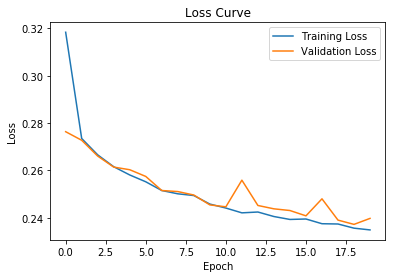

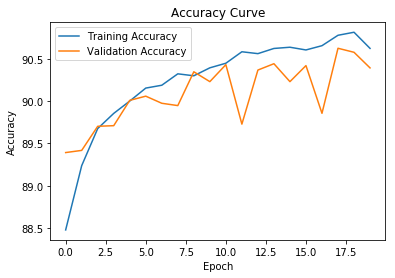

Test: [0/110]	Time 0.044 (0.044)	Loss 0.2327 (0.2327)	Accuracy 90.000 (90.000)
Test: [50/110]	Time 0.006 (0.007)	Loss 0.2303 (0.2430)	Accuracy 90.000 (90.392)
Test: [100/110]	Time 0.007 (0.006)	Loss 0.2699 (0.2417)	Accuracy 89.000 (90.485)


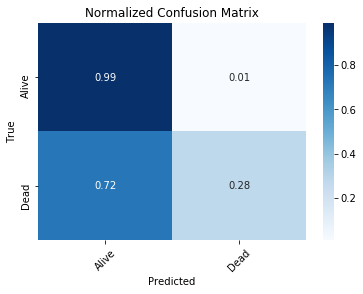

In [82]:
# train model

model = MyVariableRNN(num_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(PATH_OUTPUT, "MyVariableRNN_chartLab24.pth"))

best_model = torch.load(os.path.join(PATH_OUTPUT, "MyVariableRNN_chartLab24.pth"))
# TODO: For your report, try to make plots similar to those in the previous task.
# TODO: You may use the validation set in case you cannot use the test set.

plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
valid_loss, valid_accuracy, valid_results = evaluate(best_model, device, valid_loader, criterion)
class_names = ['Alive', 'Dead']
plot_confusion_matrix(valid_results, class_names)

In [83]:
# prediction on test dataset
def predict_mortality(model, device, data_loader):
	model.eval()
	probas = []
	    
	for i, (inputs, targets) in enumerate(data_loader):
		outputs = model(inputs)
		probas.extend(torch.sigmoid(outputs)[:, 1])
  
	return probas

test_prob = predict_mortality(best_model, device, test_loader)

In [84]:
preds = [i.item() for i in test_prob]

In [85]:
import numpy as np
from sklearn import metrics
y = test_label
fpr, tpr, thresholds = metrics.roc_curve(y, preds, pos_label=1)
metrics.auc(fpr, tpr)

0.8696992363513194

In [86]:
metrics.roc_auc_score(y, preds)

0.8696992363513194